### 导入库和数据

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
train_set = pd.read_csv('./train_set.csv', sep='\t')
X_train, X_test, y_train, y_test = train_test_split(
    train_set['text'], 
    train_set['label'], 
    random_state=42
)

In [8]:
sequence_length = 3000
embedding_dimension = 256
num_words = 8000

In [9]:
X_train = np.array([np.array([int(y) for y in x.split()]) for x in tqdm(X_train.to_list())])
X_test = np.array([np.array([int(y) for y in x.split()]) for x in tqdm(X_test.to_list())])

  0%|          | 0/150000 [00:00<?, ?it/s]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


  0%|          | 0/50000 [00:00<?, ?it/s]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [10]:
X_train, X_test = pad_sequences(X_train, maxlen=sequence_length), pad_sequences(X_test,maxlen=sequence_length)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=14)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=14)

### 单向RNN

In [7]:
model_save_path = "./rnn1.h5"
single_rnn_model = keras.models.Sequential([
    layers.Embedding(input_dim=num_words,
                     output_dim=embedding_dimension,
                     input_length=sequence_length),
    layers.SimpleRNN(units=64, return_sequences=False),  #False 只返回最后一层
    layers.Dense(64, activation='relu'),
    layers.Dense(14, activation='softmax')
])

single_rnn_model.compile(optimizer=keras.optimizers.Adam(),
                         loss=keras.losses.CategoricalCrossentropy(),
                         metrics=[tfa.metrics.F1Score(num_classes=14, average='macro')])

single_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3000, 256)         2048000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                20544     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 14)                910       
Total params: 2,073,614
Trainable params: 2,073,614
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = single_rnn_model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Epoch 1/5
2110/2110 [==============================] - 3515s 2s/step - loss: 1.4918 - categorical_accuracy: 0.5209 - val_loss: 1.1576 - val_categorical_accuracy: 0.6291
Epoch 2/5
2110/2110 [==============================] - 3478s 2s/step - loss: 1.2087 - categorical_accuracy: 0.6088 - val_loss: 1.3457 - val_categorical_accuracy: 0.5322
Epoch 3/5
2110/2110 [==============================] - 3558s 2s/step - loss: 1.6635 - categorical_accuracy: 0.4594 - val_loss: 1.6653 - val_categorical_accuracy: 0.4844
Epoch 4/5
2110/2110 [==============================] - 3562s 2s/step - loss: 1.3123 - categorical_accuracy: 0.5740 - val_loss: 1.2377 - val_categorical_accuracy: 0.6025
Epoch 5/5
2110/2110 [==============================] - 3571s 2s/step - loss: 1.1474 - categorical_accuracy: 0.6284 - val_loss: 1.2670 - val_categorical_accuracy: 0.5912


In [8]:
# 保存模型
single_rnn_model.save(model_save_path)

绘图

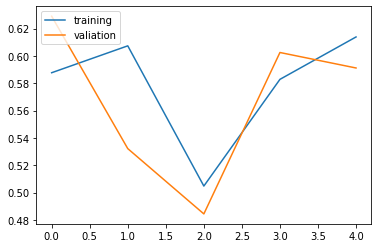

In [9]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()

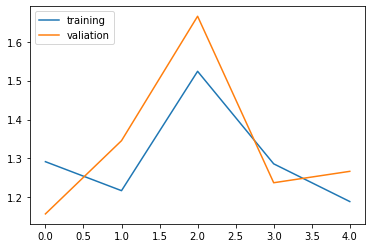

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()

测试

In [11]:
result = single_rnn_model.evaluate(X_test, y_test)
print("loss=%s,accuracy=%s" %(result[0],result[1]))

1563/1563 [==============================] - 379s 242ms/step - loss: 1.2683 - categorical_accuracy: 0.5899
loss=1.2682503461837769,accuracy=0.5898799896240234


In [ ]:
y_pred = single_rnn_model.predict(X_test)
f1_score([np.argmax(x) for x in y_test], [np.argmax(x) for x in y_pred], average='macro')

### LSTM

In [11]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [12]:
model_save_path = "./lstm.h5"
bidirection_lstm_model = keras.models.Sequential([
    layers.Embedding(input_dim=num_words,
                     output_dim=embedding_dimension,
                     input_length=sequence_length),
    layers.Bidirectional(layers.LSTM(units=64,
                                     return_sequences=True)),  # True 返回多层
    layers.Bidirectional(layers.LSTM(units=64, return_sequences=False)),
    layers.Dense(64, activation='relu'),
    layers.Dense(14, activation='softmax')
])

bidirection_lstm_model.compile(optimizer=keras.optimizers.Adam(),
                               loss=keras.losses.CategoricalCrossentropy(),
                               metrics=[keras.metrics.CategoricalAccuracy()])

bidirection_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3000, 256)         2048000   
_________________________________________________________________
bidirectional (Bidirectional (None, 3000, 128)         164352    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 14)                910       
Total params: 2,320,334
Trainable params: 2,320,334
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = bidirection_lstm_model.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Epoch 1/5


CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node Adam/Adam/update/AssignSubVariableOp/_33}}]]
	 [[gradient_tape/sequential/embedding/embedding_lookup/Reshape/_30]] [Op:__inference_train_function_10759]

Function call stack:
train_function


In [ ]:
model_save_path = "./lstm0.h5"
# 保存模型
bidirection_lstm_model.save(model_save_path)

绘图

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()

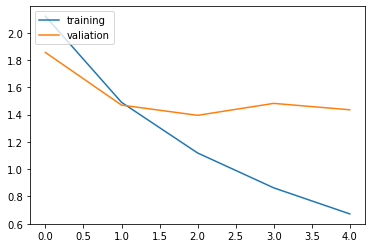

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'valiation'], loc='upper left')
plt.show()

测试

In [9]:
result = bidirection_lstm_model.evaluate(X_test, y_test)
print("loss=%s,accuracy=%s" %(result[0],result[1]))

40/40 [==============================] - 116s 3s/step - loss: 1.3793 - categorical_accuracy: 0.6368
loss=1.3793232440948486,accuracy=0.6367999911308289


In [ ]:
y_pred = bidirection_lstm_model.predict(X_test)

In [12]:
f1_score([np.argmax(x) for x in y_test], [np.argmax(x) for x in y_pred], average='macro')

0.3911772436616592

### GRU

In [8]:
GRU = keras.models.Sequential([
    layers.Embedding(input_dim=num_words,
                     output_dim=embedding_dimension,
                     input_length=sequence_length),
    layers.GRU(16),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(14, activation='softmax')
])

GRU.compile(optimizer=keras.optimizers.Adam(),
            loss=keras.losses.CategoricalCrossentropy(),
            metrics=[tfa.metrics.F1Score(num_classes=14, average='macro')])

GRU.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3000, 256)         2048000   
_________________________________________________________________
gru (GRU)                    (None, 16)                13152     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1088      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 14)                910       
Total params: 2,063,150
Trainable params: 2,063,150
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = GRU.fit(X_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Epoch 1/5
2110/2110 [==============================] - ETA: 0s - loss: 0.8637 - f1_score: 0.5834

C:\Users\陈继延\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


2110/2110 [==============================] - 341s 160ms/step - loss: 0.8637 - f1_score: 0.5834 - val_loss: 0.3707 - val_f1_score: 0.8340
Epoch 2/5
2110/2110 [==============================] - 331s 157ms/step - loss: 0.3174 - f1_score: 0.8588 - val_loss: 0.2771 - val_f1_score: 0.8880
Epoch 3/5
2110/2110 [==============================] - 326s 154ms/step - loss: 0.2322 - f1_score: 0.9061 - val_loss: 0.2448 - val_f1_score: 0.9102
Epoch 4/5
2110/2110 [==============================] - 325s 154ms/step - loss: 0.1876 - f1_score: 0.9289 - val_loss: 0.2388 - val_f1_score: 0.9145
Epoch 5/5
2110/2110 [==============================] - 329s 156ms/step - loss: 0.1563 - f1_score: 0.9410 - val_loss: 0.2572 - val_f1_score: 0.9101


In [12]:
from sklearn.metrics import f1_score
y_pred = GRU.predict(X_test)
f1_score([np.argmax(x) for x in y_test], [np.argmax(x) for x in y_pred], average='macro')

0.9082153411463867